In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda,BatchNormalization
from tensorflow.keras.models import Model
from keras.optimizers import Adam
import numpy as np

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

In [3]:
import pandas as pd

In [22]:
def processImage(input_path, target_size=(819, 1137)):    
    # Cargar la imagen
    img = cv2.imread(input_path)
    
    # Calcular la relación de aspecto
    aspect_ratio = img.shape[1] / img.shape[0]
    aspect_ratio_target = target_size[1] / target_size[0]
    
    # Determinar el nuevo tamaño manteniendo la relación de aspecto
    if aspect_ratio_target > aspect_ratio:
        new_height = img.shape[0]
        new_width = int(aspect_ratio_target * img.shape[0])
    else:
        new_height = int(img.shape[1] / aspect_ratio_target)
        new_width = img.shape[1]
    
    # Crear una nueva imagen con fondo blanco
    new_img = np.ones((new_height, new_width, 3), dtype=np.uint8) * 255
    
    # Calcular las coordenadas para centrar la imagen redimensionada
    top_left_x = (new_width - img.shape[1]) // 2
    top_left_y = (new_height - img.shape[0]) // 2
    
    # Pegar la imagen redimensionada en la nueva imagen con fondo blanco
    new_img[top_left_y:top_left_y + img.shape[0], top_left_x:top_left_x + img.shape[1]] = img
    
    # Redimensionar la imagen al tamaño objetivo
    new_img = cv2.resize(new_img, (target_size[1],target_size[0]))
    # Convertir la imagen a escala de grises
    imagen_gris = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    # Aplicar el algoritmo de Otsu para obtener el umbral óptimo
    _, umbral = cv2.threshold(imagen_gris, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Invertir la imagen
    imagen_invertida = 255 - umbral
    return imagen_invertida

def extraerDataset(folder,input_shape):
    textodataset="firmaOriginal,firmaComparacion,EsValida\n"
    dataset=[]
    for subfolder in os.listdir(folder):    
        if "forg" not in subfolder:
            print(subfolder)
            rutaSubfolderA=folder+"\\"+subfolder #obtenemos la ruta de la carpeta firmas originales
            rutaSubfolderB=folder+"\\"+subfolder+"_forg"#obtenemos la ruta de la carpeta de firmas falsas
            for imagen in os.listdir(rutaSubfolderA):
                imagenA=processImage(rutaSubfolderA+"\\"+imagen,input_shape)
                dataset.extend([([imagenA,processImage(rutaSubfolderA+"\\"+imagenReal,input_shape)],1) for imagenReal in os.listdir(rutaSubfolderA) if imagenReal!=imagen])            
                textodataset+="\n".join([imagen+","+imagenReal+","+str(1) for imagenReal in os.listdir(rutaSubfolderA) if imagenReal!=imagen])+"\n"
                dataset.extend([([imagenA,processImage(rutaSubfolderB+"\\"+imagenFalsa,input_shape)],0) for imagenFalsa in os.listdir(rutaSubfolderB)])            
                textodataset+="\n".join([imagen+","+imagenFalsa+","+str(0) for imagenFalsa in os.listdir(rutaSubfolderB)])+"\n"
    # Abrir un archivo CSV para escribir
    with open('dataset.csv', 'w', newline='') as csvfile:
        # Crear un objeto escritor CSV
        csvwriter = csv.writer(csvfile)

        lines = textodataset.split('\n')
        # Escribir cada línea en el archivo CSV
        for line in lines:
            # Separar cada línea en columnas
            row = line.split(',')
            csvwriter.writerow(row)
    return dataset

In [5]:
def build_siamese_model(input_shape):
    # Definición de la arquitectura de la subred
    input = Input(shape=input_shape)
    x = Conv2D(30, (4, 4), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)
    x = Conv2D(80, (4, 4), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)
    x = Conv2D(100, (4, 4), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)
    x = Conv2D(200, (2, 2), activation='relu')(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    model = Model(inputs=input, outputs=x)
    return model

def euclidean_distance(vectors):
    x, y = vectors
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(sum_square)

def build_complete_siamese_network(input_shape):
    # Crear la subred
    base_network = build_siamese_model(input_shape)
    
    # Entradas para las dos imágenes
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    
    # Obtener la representación de las imágenes usando la misma red
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    
    # Calcular la distancia euclidiana
    distance = Lambda(euclidean_distance)([processed_a, processed_b])

    # Modelo final
    model = Model(inputs=[input_a, input_b], outputs=distance)
    return model
 
def contrastive_loss(y_true, y_pred):
    margin = 1
    return tf.reduce_mean(y_true * tf.square(y_pred) + (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0)))

In [6]:
x=np.arange(0,1,0.01)
y=[contrastive_loss(1.0,i) for i in x]

In [7]:
y2=[contrastive_loss(0.0,i) for i in x]

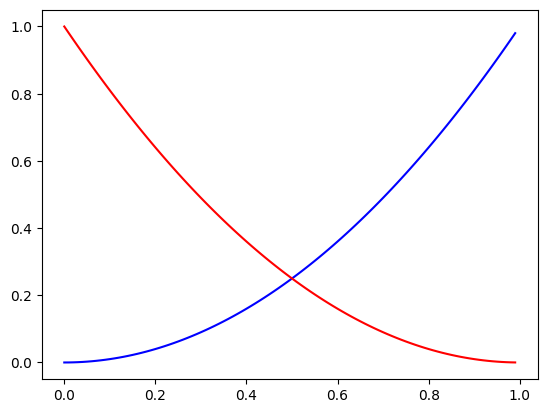

In [8]:
plt.plot(x,y,'blue')
plt.plot(x,y2,'red')

In [9]:
for i in range (10):
    if i%2==0:
        print(1,' ',-i/10,' ',contrastive_loss(1,-i/10))
    else:
        print(0,' ',-i/10,' ',contrastive_loss(0,-i/10))

1   0.0   tf.Tensor(0.0, shape=(), dtype=float32)
0   -0.1   tf.Tensor(1.21, shape=(), dtype=float32)
1   -0.2   tf.Tensor(0.040000003, shape=(), dtype=float32)
0   -0.3   tf.Tensor(1.6899998, shape=(), dtype=float32)
1   -0.4   tf.Tensor(0.16000001, shape=(), dtype=float32)
0   -0.5   tf.Tensor(2.25, shape=(), dtype=float32)
1   -0.6   tf.Tensor(0.36, shape=(), dtype=float32)
0   -0.7   tf.Tensor(2.89, shape=(), dtype=float32)
1   -0.8   tf.Tensor(0.64000005, shape=(), dtype=float32)
0   -0.9   tf.Tensor(3.61, shape=(), dtype=float32)


In [10]:
# Datos de entrenamiento
dataset=extraerDataset("data",(200,100))
pairs_train_a = np.array([item[0][0] for item in dataset],dtype=np.float32)
pairs_train_b = np.array([item[0][1] for item in dataset],dtype=np.float32)
labels_train = np.array([item[1] for item in dataset] , dtype=np.float32)

049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069


a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 1.0


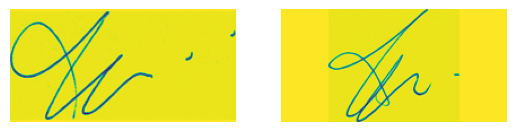

a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 1.0


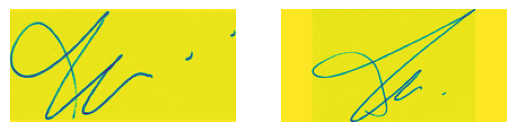

In [11]:
for i in range(0,2,1):
    a=pairs_train_a[i]
    b=pairs_train_b[i]
    y=labels_train[i]
    print(f'a shape={a.shape}, dtype={a.dtype}')
    print(f'b shape={b.shape}, dtype={b.dtype}')
    print(f'y shape={y.shape}, dtype={y.dtype} {y}')
    fig, axes = plt.subplots(1, 2)
    # Mostrar la primera imagen en el subplot 1
    axes[0].imshow(a)
    axes[0].axis('off')  # Opcional: Oculta los ejes
    # Mostrar la segunda imagen en el subplot 2
    axes[1].imshow(b)
    axes[1].axis('off')
    plt.show()

In [12]:
model = build_complete_siamese_network((100, 200, 1))  # Tamaño de imagen ejemplo
model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.001))

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 100, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 4096)         138028610   ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [14]:
# Entrenar el modelo
history=model.fit([pairs_train_a,pairs_train_b], labels_train, epochs=15, batch_size=64)

Epoch 1/15
90/90 [==============================] - 13s 105ms/step - loss: 216.0401
Epoch 2/15
90/90 [==============================] - 9s 98ms/step - loss: 34.3716
Epoch 3/15
90/90 [==============================] - 9s 98ms/step - loss: 22.6232
Epoch 4/15
90/90 [==============================] - 9s 98ms/step - loss: 21.0874
Epoch 5/15
90/90 [==============================] - 9s 98ms/step - loss: 11.1446
Epoch 6/15
90/90 [==============================] - 9s 99ms/step - loss: 11.0252
Epoch 7/15
90/90 [==============================] - 9s 99ms/step - loss: 9.6470
Epoch 8/15
90/90 [==============================] - 9s 99ms/step - loss: 9.5534
Epoch 9/15
90/90 [==============================] - 9s 99ms/step - loss: 5.4167
Epoch 10/15
90/90 [==============================] - 9s 100ms/step - loss: 5.7718
Epoch 11/15
90/90 [==============================] - 9s 98ms/step - loss: 4.0534
Epoch 12/15
90/90 [==============================] - 9s 97ms/step - loss: 4.4047
Epoch 13/15
90/90 [========

In [21]:
salida=model.evaluate([pairs_train_a,pairs_train_b], labels_train)
salida

180/180 [==============================] - 3s 14ms/step - loss: 9.1144


9.114448547363281

In [22]:
resultado=model.predict([pairs_train_a,pairs_train_b])
len(resultado)

180/180 [==============================] - 3s 15ms/step


5748

In [50]:
data={
    'verdadero':labels_train,
    'predicho':list(resultado)
}
df = pd.DataFrame(data)
df['final']=df['predicho'].apply(lambda x:0 if x>4.5 else 1)
df['comparacion']=df['verdadero']==df['final']
df['comparacion'].value_counts()

comparacion
True     4708
False    1040
Name: count, dtype: int64

In [43]:
df['comparacion'].value_counts()

comparacion
True     4733
False    1015
Name: count, dtype: int64

1/1 [==============================] - 0s 13ms/step
a shape=(100, 200), dtype=float64
b shape=(100, 200), dtype=float64
33.39897918701172


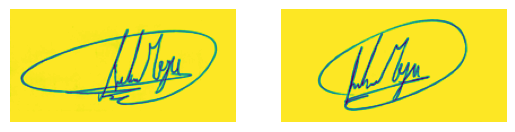

In [55]:
for i in range(1):
    imagenA="1.jpeg"
    imagenB=f"3.jpeg"
    a=processImage(imagenA) 
    b=processImage(imagenB) 
    prediction=model.predict([np.array([a]),np.array([b])])[0][0]
    print(f'a shape={a.shape}, dtype={a.dtype}')
    print(f'b shape={b.shape}, dtype={b.dtype}')
    print(f'{prediction}')
    fig, axes = plt.subplots(1, 2)
    # Mostrar la primera imagen en el subplot 1
    axes[0].imshow(a)
    axes[0].axis('off')  # Opcional: Oculta los ejes
    # Mostrar la segunda imagen en el subplot 2
    axes[1].imshow(b)
    axes[1].axis('off')
    plt.show()

In [ ]:
a.shape

(100, 200)

1/1 [==============================] - 0s 13ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 1.0-4.808241367340088


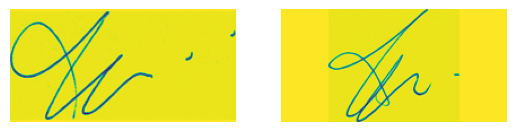

1/1 [==============================] - 0s 14ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 1.0-4.260509014129639


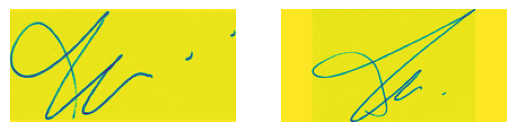

1/1 [==============================] - 0s 14ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 1.0-6.606947898864746


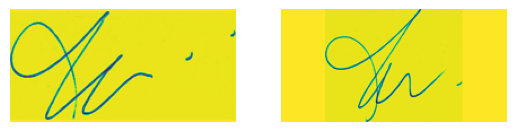

1/1 [==============================] - 0s 14ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 1.0-3.2082622051239014


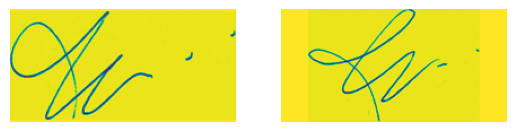

1/1 [==============================] - 0s 14ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 1.0-4.022759914398193


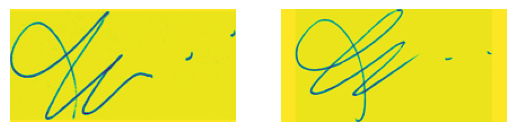

1/1 [==============================] - 0s 14ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 1.0-5.636755466461182


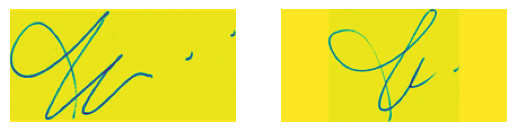

1/1 [==============================] - 0s 13ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 1.0-2.7060606479644775


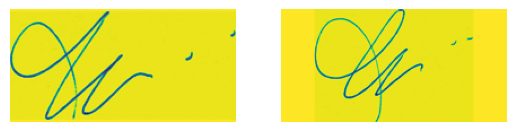

1/1 [==============================] - 0s 13ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 1.0-2.3825886249542236


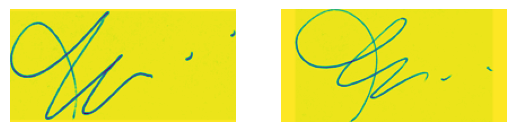

1/1 [==============================] - 0s 14ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 1.0-4.750835418701172


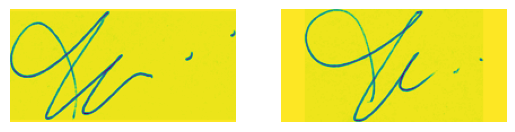

1/1 [==============================] - 0s 14ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 1.0-1.7151672840118408


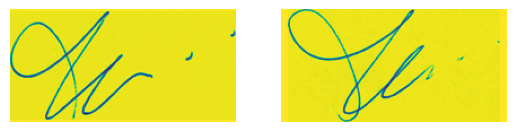

1/1 [==============================] - 0s 14ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 1.0-1.826128363609314


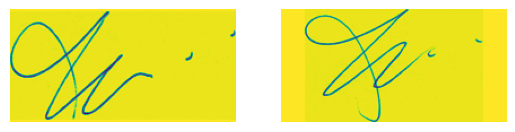

1/1 [==============================] - 0s 14ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 0.0-8.98091983795166


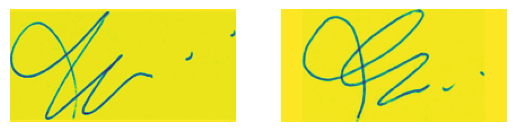

1/1 [==============================] - 0s 12ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 0.0-6.512411594390869


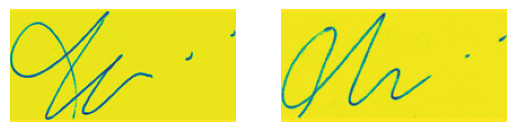

1/1 [==============================] - 0s 15ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 0.0-5.011231422424316


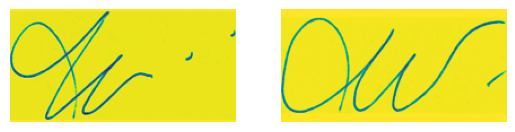

1/1 [==============================] - 0s 15ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 0.0-4.694509983062744


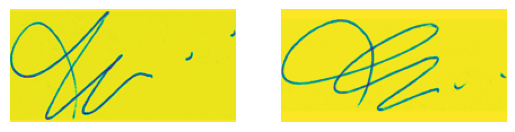

1/1 [==============================] - 0s 15ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 0.0-7.574237823486328


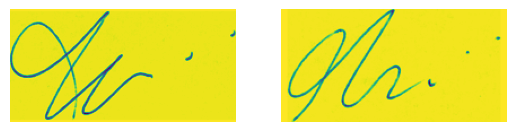

1/1 [==============================] - 0s 19ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 0.0-15.078278541564941


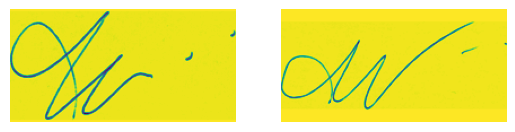

1/1 [==============================] - 0s 13ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 0.0-7.516665458679199


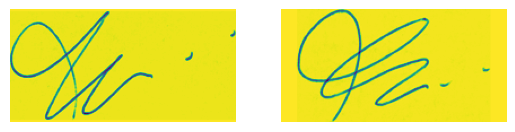

1/1 [==============================] - 0s 13ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 0.0-9.077526092529297


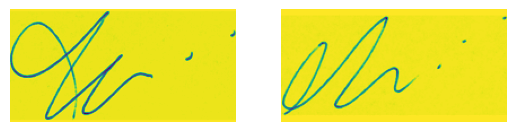

1/1 [==============================] - 0s 14ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 0.0-11.93159008026123


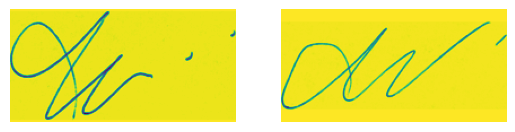

1/1 [==============================] - 0s 17ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 0.0-3.3821511268615723


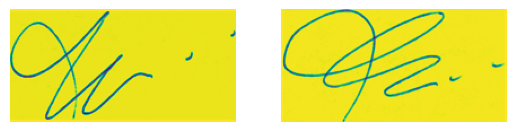

1/1 [==============================] - 0s 13ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 0.0-7.420032978057861


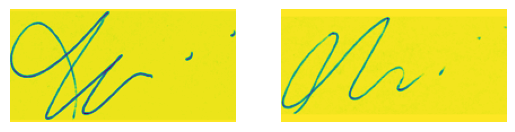

1/1 [==============================] - 0s 11ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 0.0-4.671428680419922


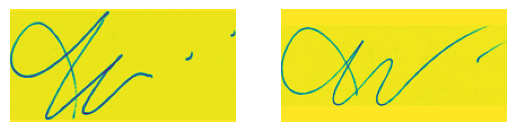

1/1 [==============================] - 0s 13ms/step
a shape=(100, 200), dtype=float32
b shape=(100, 200), dtype=float32
y shape=(), dtype=float32 1.0-4.808241367340088


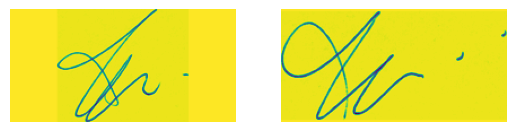

In [52]:
for i in range(0,24,1):
    a=pairs_train_a[i]
    b=pairs_train_b[i]
    y=labels_train[i]
    prediction=model.predict([np.array([a]),np.array([b])])[0][0]
    print(f'a shape={a.shape}, dtype={a.dtype}')
    print(f'b shape={b.shape}, dtype={b.dtype}')
    print(f'y shape={y.shape}, dtype={y.dtype} {y}-{prediction}')
    fig, axes = plt.subplots(1, 2)
    # Mostrar la primera imagen en el subplot 1
    axes[0].imshow(a)
    axes[0].axis('off')  # Opcional: Oculta los ejes
    # Mostrar la segunda imagen en el subplot 2
    axes[1].imshow(b)
    axes[1].axis('off')
    plt.show()